# Export Growth Prediction

## Model 1: Multivariate Linear Regression with Categorical Variable

Hypothesis:

$$
(\log Ex - \overline{\log Ex_c}) =
\theta_{0} +
\theta_{1}(g_{GDP} - \overline{{g_{GDP}}_c}) +
\theta_{2}(\log GDP_{capita} - \overline{{\log GDP_{capita}}_c}) +
\theta_{3}(\log Im - \overline{{\log Im}_c}) + \epsilon
$$

where:  
* $Ex$ = export value of Taiwan (in USD)
* $g_{GDP}$ = annual % growth of real GDP of the importing country
* $GDP_{capita}$ = GDP per capita of the importing country (in USD)
* $Im$ = import value of the importing country (in million USD)

and $\overline{\log Ex_c}$, $\overline{{g_{GDP}}_c}$, $\overline{{\log GDP_{capita}}_c}$, $\overline{{\log Im}_c}$ are means over all years of the respective values for country $c$. Also known as the fixed effects model.

#### Preprocessing

In [1]:
import pandas as pd
import numpy as np

def read_lr_data(drop_im_growth=True):
    path = 'C:/Users/2093/Desktop/Data Center/07. 出口預測/2017/data/model.data80_merge_import.xlsx'
    lr_df = pd.read_excel(path)
    names = ['country', 'year', 'gdp_growth', 'ex', 'gdp_capita', 'im_growth', 'im']
    if drop_im_growth:
        lr_df.drop('import_g', axis=1, inplace=True)
        names.remove('im_growth')
    lr_df.columns = names
    lr_df['year'] = pd.to_datetime(lr_df['year'], format='%Y')
    lr_df = lr_df.set_index(['year', 'country']).sort_index()
    return lr_df
lr_df = read_lr_data()

def percent_change(data, groupby, col):
    rs = (data.groupby(level=groupby)[col].transform(pd.Series.diff)
          / data.groupby(level=groupby)[col].transform(pd.Series.shift) * 100)
    return rs
# Compute export growth
lr_df['ex_growth'] = percent_change(lr_df, groupby='country', col='ex')

# Keep only complete cases and remove rows where import value is zero (ITC has no data)
lr_df = lr_df.dropna().query('im != 0')
# Because ITC import values are in thousand USD, multiply by .001
lr_df['im'] = lr_df['im'] * .001
# Take logarithms
lr_df[['ex', 'gdp_capita', 'im']] = lr_df[['ex', 'gdp_capita', 'im']].apply(np.log)

#### Some helper classes and functions

In [2]:
import re

class GroupMeanNormalizer(object):
    """Transform data by substracting group mean from group members.
    
    The groupby variable ``groupby`` must be a MultiIndex level.
    """
    def __init__(self, data, groupby):
        self.groupby = groupby
        self.means = data.groupby(level=groupby).mean()
        self.level_ind = data.index.names.index(self.groupby)
        
    def transform(self, data):
        df = data.groupby(level=self.groupby).apply(
            lambda g: g - self.means.loc[g.index.values[0][self.level_ind]])
        return df
    
    def inverse_transform(self, data):
        df = data.groupby(level=self.groupby).apply(
            lambda g: g + self.means.loc[g.index.values[0][self.level_ind]])
        return df

In [3]:
from sklearn.preprocessing import StandardScaler

class Standardizer(StandardScaler):
    """Modified StandardScaler that returns a DataFrame instead of an array."""

    def __init__(self, X):
        super(Standardizer, self).__init__()
        super(Standardizer, self).fit(X)
        
    def transform(self, X):
        df = pd.DataFrame(super(Standardizer, self).transform(X)).set_index(X.index)
        df.columns = X.columns
        return df
        
    def inverse_transform(self, X):
        df = pd.DataFrame(super(Standardizer, self).inverse_transform(X)).set_index(X.index)
        df.columns = X.columns
        return df

In [4]:
def compute_g_pred(y_pred, y_actual, g_actual):
    """Compute predicted % growth using predicted log(y), actual log(y), and actual % growth.
    
    Keyword arguments:
    ------------------
    y_pred -- predicted log(y)
    y_actual -- actual log(y)
    g_actual -- actual % growth
    """
    g_pred = 100 * (np.exp(y_pred - (np.log(100)+y_actual) + np.log(g_actual+100)) - 1)
    return g_pred

#### Model Training and Evaluation Framework

In [5]:
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from tabulate import tabulate

idx = pd.IndexSlice

class ExportGrowthModel(object):
    
    def __init__(self, data, X, y, model, cv_method, normalize=False, scale=False, n_splits=None,
                 n_train=None, **kwargs):
        
        self.X = X
        self.y = y
        self.model = model
        self.normalize = normalize
        self.scale = scale
        self.kwargs = kwargs
        
        if cv_method == 'most_recent':
            min_year = str(data.index.get_level_values('year').year.min())
            self.test_year = str(data.index.get_level_values('year').year.max())
            X_train = data.loc[idx[min_year:str(int(self.test_year)-1), :], X]
            X_test = data.loc[idx[self.test_year, :], X]
            if self.model == 'lr_export':
                y_train = data.loc[idx[min_year:str(int(self.test_year)-1), :], [y, 'ex_growth']]
                y_test = data.loc[idx[self.test_year, :], [y, 'ex_growth']]
            else:
                y_train = data.loc[idx[min_year:str(int(self.test_year)-1), :], [y]]
                y_test = data.loc[idx[self.test_year, :], [y]]
            self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
            self._fit()
            self._predict()
            self._evaluate()
            self._summary()
        
        elif cv_method == 'leave_one_out':
            train_errors = []
            test_errors = []
            for yr in pd.Series(data.index.get_level_values('year').year).unique():
                X_train = data.loc[data.index.get_level_values('year').year != yr, X]
                X_test = data.loc[idx[str(yr), :], X]
                if self.model == 'lr_export':
                    y_train = data.loc[data.index.get_level_values('year').year != yr, [y, 'ex_growth']]
                    y_test = data.loc[idx[str(yr), :], [y, 'ex_growth']]
                else:
                    y_train = data.loc[data.index.get_level_values('year').year != yr, [y]]
                    y_test = data.loc[idx[str(yr), :], [y]]
                self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
                self._fit()
                self._predict()
                self._evaluate()
                train_errors.append(self.train_error)
                test_errors.append(self.test_error)
            self.cv_train_error = pd.Series(train_errors).mean()
            self.cv_test_error = pd.Series(test_errors).mean()
            print('Leave-one-out cv errors:\n- {:5}:{:8.4f}\n- {:5}:{:8.4f}'.format(
                    'Train', self.cv_train_error, 'Test', self.cv_test_error))
                
        elif cv_method == 'skf':
            train_errors = []
            test_errors = []
            skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=7)
            for train_index, test_index in skf.split(data, data.index.get_level_values('country')):
                X_train = data.ix[train_index, X]
                X_test = data.ix[test_index, X]
                if self.model == 'lr_export':
                    y_train = data.ix[train_index, [y, 'ex_growth']]
                    y_test = data.ix[test_index, [y, 'ex_growth']]
                else:
                    y_train = data.ix[train_index, [y]]
                    y_test = data.ix[test_index, [y]]
                self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
                self._fit()
                self._predict()
                self._evaluate()
                train_errors.append(self.train_error)
                test_errors.append(self.test_error)
            self.cv_train_error = pd.Series(train_errors).mean()
            self.cv_test_error = pd.Series(test_errors).mean()
            print('Stratefied {}-fold cv errors:\n- {:5}:{:8.4f}\n- {:5}:{:8.4f}'.format(
                    n_splits, 'Train', self.cv_train_error, 'Test', self.cv_test_error))
            
        elif cv_method == 'sampling':
            data = shuffle(data, random_state=7)
            if self.model == 'lr_export':
                X_train, X_test, y_train, y_test = train_test_split(
                    data[X], data[[y, 'ex_growth']],
                    test_size=0.3, random_state=3, stratify=data.index.get_level_values('country'))
            else:
                X_train, X_test, y_train, y_test = train_test_split(
                    data[X], data[[y]],
                    test_size=0.3, random_state=3, stratify=data.index.get_level_values('country'))
            X_train, y_train = X_train.iloc[:n_train,], y_train.iloc[:n_train,]
            self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
            self._fit()
            self._predict()
            self._evaluate()

        else:
            raise ValueError('Invalid cv_method. Must be one of "most_recent", "leave_one_out", \
            "skf", or "sampling"')
            
    def _fit(self):
        
        if self.normalize:
            self.X_normalizer = GroupMeanNormalizer(self.X_train, groupby='country')
            self.y_normalizer = GroupMeanNormalizer(self.y_train, groupby='country')
            self.X_train = self.X_normalizer.transform(self.X_train)
            self.y_train = self.y_normalizer.transform(self.y_train)
        elif self.scale:
            self.X_scaler = Standardizer(self.X_train)
            self.y_scaler = Standardizer(self.y_train)
            self.X_train = self.X_scaler.transform(self.X_train)
            self.y_train = self.y_scaler.transform(self.y_train)

        models = dict(
            lr_export=LinearRegression(),
            lr_growth=LinearRegression(),
            svr=SVR(),
            rf=RandomForestRegressor(),
            ada=AdaBoostRegressor(),
            gbrt=GradientBoostingRegressor()
        )
        self.regr = models[self.model]
        self.regr.set_params(**self.kwargs)
        
        if self.model == 'lr_export':
            self.regr.fit(self.X_train, self.y_train.drop('ex_growth', axis=1).values.ravel())
        else:
            self.regr.fit(self.X_train, self.y_train.values.ravel())
        if self.model == 'lr_export' or self.model == 'lr_growth': self.coef_ = self.regr.coef_

        if self.normalize: self.y_train = self.y_normalizer.inverse_transform(self.y_train)
        if self.scale: self.y_train = self.y_scaler.inverse_transform(self.y_train)
    
    def _predict(self):
        
        if self.normalize: self.X_test = self.X_normalizer.transform(self.X_test)
        if self.scale: self.X_test = self.X_scaler.transform(self.X_test)
        
        def pred(X_data, y_data):
            y_pred = pd.DataFrame({self.y: self.regr.predict(X_data)}).set_index(X_data.index)
            if self.normalize: y_pred = self.y_normalizer.inverse_transform(y_pred)
            if self.scale: y_pred = self.y_scaler.inverse_transform(y_pred)
            y_data[self.y + '_pred'] = y_pred[self.y].tolist()
            if self.model == 'lr_export':
                y_data['ex_growth_pred'] = compute_g_pred(
                    y_data[self.y + '_pred'], y_data[self.y], y_data['ex_growth'])
            return y_data
        
        self.y_train = pred(self.X_train, self.y_train)
        self.y_test = pred(self.X_test, self.y_test)
        self.result = self.y_test
    
    @staticmethod
    def rmse(actual, pred):
        return np.sqrt(mean_squared_error(actual, pred))
        
    def _evaluate(self):
        
        if self.model == 'lr_export':
            self.train_error = self.rmse(self.y_train['ex_growth'], self.y_train['ex_growth_pred'])
            self.test_error = self.rmse(self.y_test['ex_growth'], self.y_test['ex_growth_pred'])
        else:
            self.train_error = self.rmse(self.y_train[self.y], self.y_train[self.y + '_pred'])
            self.test_error = self.rmse(self.y_test[self.y], self.y_test[self.y + '_pred'])       
    
    def _summary(self):

        print('- Train: {:,} data points of {} countries from {} throuth {}.\n\
- Test: {:,} data points of {} countries from {} throuth {}.\n'.format(
                len(self.X_train), self.X_train.index.get_level_values('country').nunique(),
                self.X_train.index.get_level_values('year').min().year,
                self.X_train.index.get_level_values('year').max().year,
                len(self.X_test), self.X_test.index.get_level_values('country').nunique(),
                self.X_test.index.get_level_values('year').min().year,
                self.X_test.index.get_level_values('year').max().year))

        print('Coefficients:\n')
        for x in zip(self.X, self.coef_):
            print('{:10}: {:6.4f}'.format(*x))
        
        order = [self.y, self.y + '_pred']
        if self.model == 'lr_export': order += ['ex_growth', 'ex_growth_pred']
        print('\nSummary of results:\n' +
              tabulate(self.result[order].describe(), headers='keys', tablefmt='psql') + '\n')
        print('{:14}:{:8.4f}\n{:14}:{:8.4f}'.format('Training error', self.train_error,
                                                    'Test error', self.test_error))

In [6]:
model1 = ExportGrowthModel(data=lr_df, X=['gdp_growth', 'gdp_capita', 'im'], y='ex',
                           model='lr_export', normalize=True, cv_method='most_recent')

- Train: 1,007 data points of 80 countries from 2001 throuth 2013.
- Test: 80 data points of 80 countries from 2014 throuth 2014.

Coefficients:

gdp_growth: 0.0149
gdp_capita: 0.4575
im        : 0.5429

Summary of results:
+-------+----------+-----------+-------------+------------------+
|       |       ex |   ex_pred |   ex_growth |   ex_growth_pred |
|-------+----------+-----------+-------------+------------------|
| count | 80       |  80       |    80       |         80       |
| mean  | 20.2867  |  20.317   |    -2.51924 |          6.5175  |
| std   |  1.69717 |   1.77501 |    19.7555  |         35.2405  |
| min   | 17.4054  |  16.6646  |   -70.5364  |        -94.9824  |
| 25%   | 18.846   |  18.9051  |   -12.3459  |         -6.41581 |
| 50%   | 19.8687  |  20.068   |     1.82052 |          9.96134 |
| 75%   | 21.2655  |  21.3307  |     8.80674 |         24.1087  |
| max   | 25.0705  |  25.2897  |    40.5683  |        140.309   |
+-------+----------+-----------+-------------+----

#### Leave-1-Year-Out CV and Stratefied K-Fold CV

In [7]:
ExportGrowthModel(data=lr_df, X=['gdp_growth', 'gdp_capita', 'im'], y='ex',
                  model='lr_export', normalize=True, cv_method='leave_one_out')
ExportGrowthModel(data=lr_df, X=['gdp_growth', 'gdp_capita', 'im'], y='ex',
                  model='lr_export', normalize=True, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 71.3731
- Test : 56.9389
Stratefied 5-fold cv errors:
- Train: 69.4564
- Test : 66.8216


#### Plotting Results

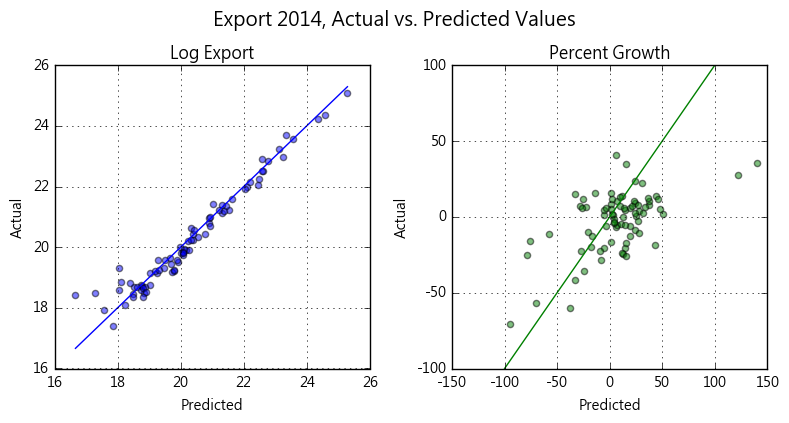

In [8]:
import matplotlib.pyplot as plt

def plot_model_comparison(
    left_data, right_data, left_x, left_y, right_x, right_y, title, left_title, right_title,
    left_refline=None, right_refline=None, left_scale=None, right_scale=None):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
    plt.suptitle(title, y=1.05, size=14)
    
    def plot_prediction(data, x, y, ax, title, c='b', refline=None, scale=None):
        data.plot(ax=axes[ax], x=x, y=y, kind='scatter', alpha=0.5, c=c, title=title)
        if refline is None:
            x_min, x_max = data[x].min(), data[x].max()
            axes[ax].plot([x_min, x_max], [x_min, x_max], c)
        else:
            axes[ax].plot(refline, refline, c)
        if scale is not None:
            axes[ax].axis(scale)
        axes[ax].set_xlabel('Predicted')
        axes[ax].set_ylabel('Actual')
        axes[ax].grid()
        return
    
    plot_prediction(data=left_data, x=left_x, y=left_y, ax=0, title=left_title,
                   refline=left_refline, scale=left_scale)
    plot_prediction(data=right_data, x=right_x, y=right_y, ax=1, title=right_title,
                    c='g', refline=right_refline, scale=right_scale)
    plt.tight_layout()
    plt.show()
    return

rs1 = model1.result
plot_model_comparison(
    left_data=rs1, right_data=rs1, left_x='ex_pred', left_y='ex',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Export {}, Actual vs. Predicted Values'.format(model1.test_year),
    left_title='Log Export', right_title='Percent Growth', right_refline=[-100, 100],
    right_scale=[-150, 150, -100, 100])

---

## Model 2: Multivariate Regression on All Percent Changes

(a) Using mean normalized % changes  
(b) Using % changes

#### Preprocessing

In [9]:
lr_df2 = read_lr_data(drop_im_growth=False)
# Compute growth in export and GDP per capita
lr_df2['ex_growth'] = percent_change(lr_df2, groupby='country', col='ex')
lr_df2['capita_growth'] = percent_change(lr_df2, groupby='country', col='gdp_capita')
# Keep only complete cases
lr_df2 = lr_df2[['ex_growth', 'gdp_growth', 'capita_growth', 'im_growth']].dropna()

#### EDA

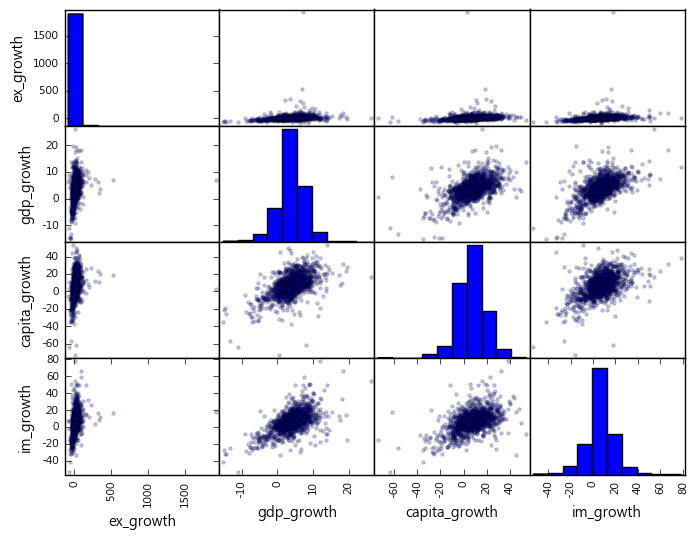

Correlation coefficients:

                ex_growth  gdp_growth  capita_growth  im_growth
ex_growth       1.000000    0.206633       0.192484   0.233350
gdp_growth      0.206633    1.000000       0.552122   0.591538
capita_growth   0.192484    0.552122       1.000000   0.502015
im_growth       0.233350    0.591538       0.502015   1.000000


In [10]:
from pandas.tools.plotting import scatter_matrix

scatter_matrix(lr_df2, alpha=0.2, figsize=(8, 6))
plt.show()
print('Correlation coefficients:\n\n', lr_df2.corr())

Clearly there are a number of extreme values. Try removing them and see if things get better.

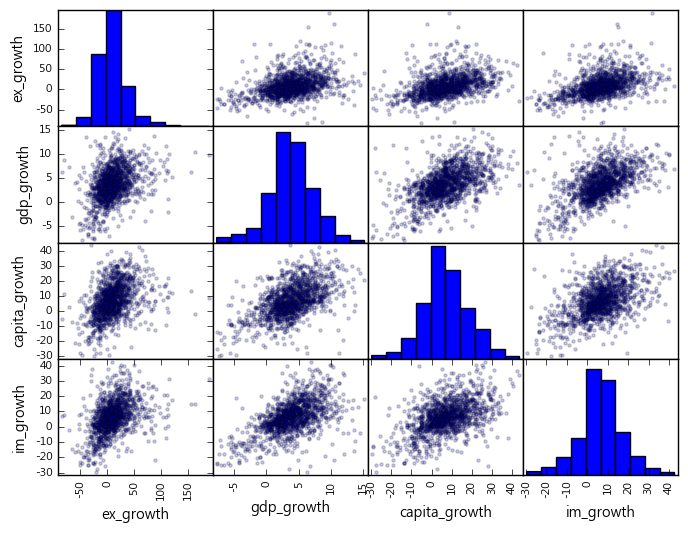

Correlation coefficients:

                ex_growth  gdp_growth  capita_growth  im_growth
ex_growth       1.000000    0.368422       0.385075   0.417567
gdp_growth      0.368422    1.000000       0.532011   0.544541
capita_growth   0.385075    0.532011       1.000000   0.489091
im_growth       0.417567    0.544541       0.489091   1.000000


In [11]:
from functools import reduce

non_outlier = (np.abs((lr_df2 - lr_df2.mean()) / lr_df2.std()) < 3).apply(
    lambda x: reduce(np.logical_and, x), axis=1)
outlier_rm = lr_df2[non_outlier]

scatter_matrix(outlier_rm, alpha=0.2, figsize=(8, 6))
plt.show()
print('Correlation coefficients:\n\n', outlier_rm.corr())

Now it looks much better.

### (a) Using Mean Normalized % Changes

- Train: 1,230 data points of 80 countries from 1998 throuth 2013.
- Test: 80 data points of 80 countries from 2014 throuth 2014.

Coefficients:

gdp_growth: 1.3296
capita_growth: 0.3595
im_growth : 0.6077

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    80       |        80        |
| mean  |    -2.51924 |         5.22278  |
| std   |    19.7555  |         9.96874  |
| min   |   -70.5364  |       -21.5347   |
| 25%   |   -12.3459  |        -0.589379 |
| 50%   |     1.82052 |         5.38345  |
| 75%   |     8.80674 |        12.0363   |
| max   |    40.5683  |        27.5887   |
+-------+-------------+------------------+

Training error: 23.8076
Test error    : 21.5827


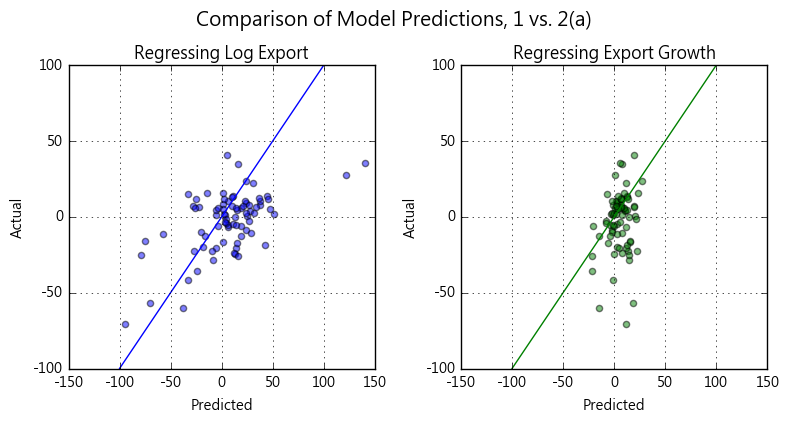

In [12]:
model2a = ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'],
                            y='ex_growth', model='lr_growth', normalize=True, cv_method='most_recent')

rs2a = model2a.result
plot_model_comparison(
    left_data=rs1, right_data=rs2a, left_x='ex_growth_pred', left_y='ex_growth',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Comparison of Model Predictions, 1 vs. 2(a)',
    left_title='Regressing Log Export', right_title='Regressing Export Growth',
    left_refline=[-100, 100], right_refline=[-100, 100],
    left_scale=[-150, 150, -100, 100], right_scale=[-150, 150, -100, 100])

In [13]:
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=True, cv_method='leave_one_out')
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=True, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 23.5746
- Test : 24.9230
Stratefied 5-fold cv errors:
- Train: 23.4448
- Test : 25.1798


### (b) Using % Changes

- Train: 1,230 data points of 80 countries from 1998 throuth 2013.
- Test: 80 data points of 80 countries from 2014 throuth 2014.

Coefficients:

gdp_growth: 1.1691
capita_growth: 0.4453
im_growth : 0.6311

Summary of results:
+-------+-------------+------------------+
|       |   ex_growth |   ex_growth_pred |
|-------+-------------+------------------|
| count |    80       |        80        |
| mean  |    -2.51924 |         4.7159   |
| std   |    19.7555  |         9.43238  |
| min   |   -70.5364  |       -34.2901   |
| 25%   |   -12.3459  |         0.579199 |
| 50%   |     1.82052 |         5.39069  |
| 75%   |     8.80674 |         9.38532  |
| max   |    40.5683  |        30.0854   |
+-------+-------------+------------------+

Training error: 24.6286
Test error    : 19.2104


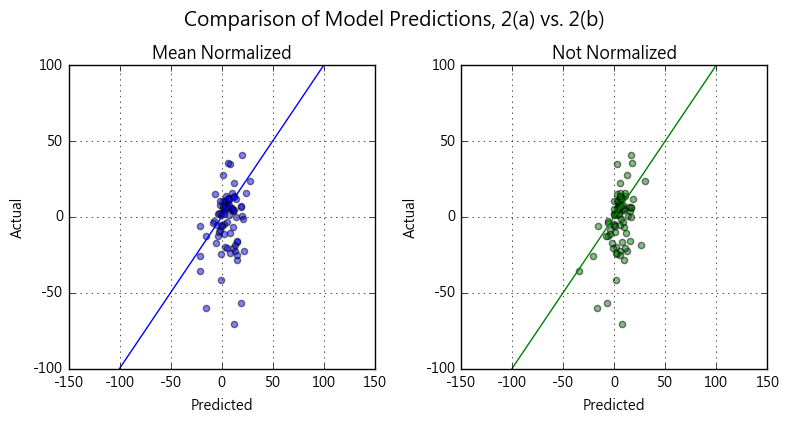

In [14]:
model2b = ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'],
                            y='ex_growth', model='lr_growth', normalize=False, cv_method='most_recent')

rs2b = model2b.result
plot_model_comparison(
    left_data=rs2a, right_data=rs2b, left_x='ex_growth_pred', left_y='ex_growth',
    right_x='ex_growth_pred', right_y='ex_growth',
    title='Comparison of Model Predictions, 2(a) vs. 2(b)',
    left_title='Mean Normalized', right_title='Not Normalized',
    left_refline=[-100, 100], right_refline=[-100, 100],
    left_scale=[-150, 150, -100, 100], right_scale=[-150, 150, -100, 100])

In [15]:
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=False, cv_method='leave_one_out')
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='lr_growth', normalize=False, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 24.3098
- Test : 24.0644
Stratefied 5-fold cv errors:
- Train: 24.3153
- Test : 24.3608


#### Learning Curves: Are More Data Likely to Help?

In [16]:
def learning_curves(data, X, model, **kwargs):
    """Plot learning curves for no. of training examples = 1 to 30% of the dataset."""
    n_trains = range(1, round(len(data) * .3))
    train_errors = []
    test_errors = []
    for n_train in n_trains:
        mdl = ExportGrowthModel(
            data=data, X=X, y='ex_growth',
            model=model, normalize=False, cv_method='sampling', n_train=n_train, **kwargs)
        train_errors.append(mdl.train_error)
        test_errors.append(mdl.test_error)
    curve_dt = pd.DataFrame(dict(n_train=n_trains, train_error=train_errors, test_error=test_errors))
    curve_dt.plot(x='n_train', y=['train_error', 'test_error'])
    plt.title('Learning Curves')
    plt.xlabel('Training Set Size')
    plt.ylabel('Error')
    plt.legend(['Train', 'Test'])
    plt.show()
    return

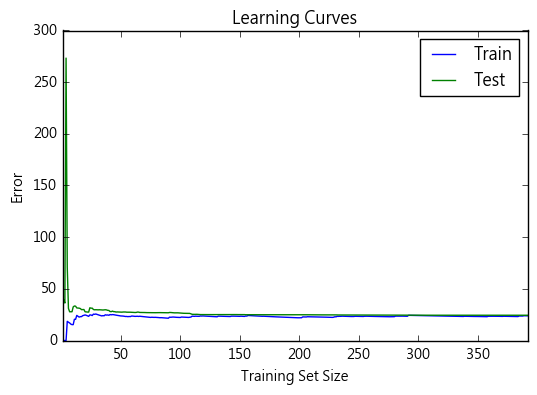

In [17]:
learning_curves(outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], model='lr_growth')

Not surprisingly, model 2(b) has high bias. Thus a test error of around 24 percentage point is the best we can expect from it.

#### Error Analysis

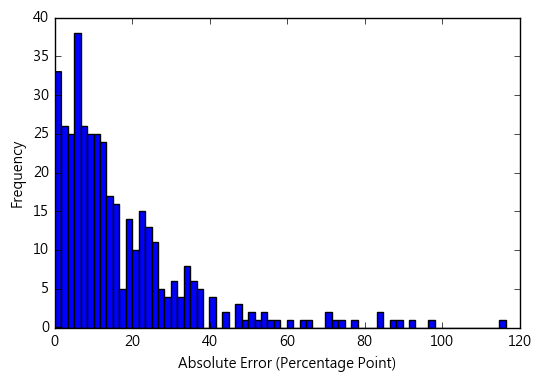

In [18]:
model = ExportGrowthModel(
    data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
    model='lr_growth', normalize=False, cv_method='sampling', n_train=round(len(outlier_rm) * .7))
model_rs = model.y_test
model_rs['ae'] = (model_rs['ex_growth'] - model_rs['ex_growth_pred']).abs()

model_rs['ae'].plot(kind='hist', bins=70)
plt.xlabel('Absolute Error (Percentage Point)')
plt.show()

In [19]:
mae = model_rs[['ae']].groupby(level='country').mean().sort_values('ae', ascending=False)
faroff = mae.head(10)
closest = mae.tail(10).iloc[::-1, :]
print('Countries with the most far-off predicted values on average:\n\n{:2}  {:23}  {:5}'.format(
        '', 'Country', 'AE'))
for lab, row in faroff.iterrows():
    print('{:2}. {:23}: {:5.2f}'.format(faroff.index.get_loc(lab)+1, lab, row['ae']))
print('\nCountries with the closest predicted values on average:\n\n{:2}  {:23}  {:5}'.format(
        '', 'Country', 'AE'))
for lab, row in closest.iterrows():
    print('{:2}. {:23}: {:5.2f}'.format(closest.index.get_loc(lab)+1, lab, row['ae']))

Countries with the most far-off predicted values on average:

    Country                  AE   
 1. Kazakhstan             : 47.70
 2. Costa Rica             : 44.72
 3. Panama                 : 41.42
 4. Mozambique             : 34.35
 5. China                  : 33.91
 6. Uruguay                : 33.89
 7. Portugal               : 32.88
 8. Kenya                  : 32.66
 9. United Rep. of Tanzania: 30.87
10. Bulgaria               : 29.77

Countries with the closest predicted values on average:

    Country                  AE   
 1. Australia              :  3.51
 2. Sweden                 :  3.95
 3. Colombia               :  4.88
 4. Thailand               :  5.24
 5. USA                    :  5.85
 6. Canada                 :  6.36
 7. Italy                  :  6.90
 8. Algeria                :  6.91
 9. Indonesia              :  7.30
10. Pakistan               :  7.65


In [20]:
from scipy.stats import zscore
from scipy.stats import f_oneway

mae['group'] = pd.cut(zscore(mae.pow(1/4)).reshape((len(mae),)),
                      bins=range(-2, 4), labels=range(1, 6), include_lowest=True)
anova_dt = read_lr_data().groupby(level='country').mean().merge(mae, left_index=True, right_index=True)

def oneway_anova(variable):
    gps = []
    for g in range(5):
        gps.append(anova_dt.loc[anova_dt['group'] == g+1, variable].values)
    return f_oneway(*gps)

variables = sorted(anova_dt.columns.drop(['ae', 'group']))
print('{:10}  {:11} {:7}'.format('Variable', 'F-statistic', 'p-value'))
for x in zip(variables, map(oneway_anova, variables)):
    print('{:10}: {:11.4f} {:7.4f}'.format(x[0], x[1][0], x[1][1]))

Variable    F-statistic p-value
ex        :      2.5825  0.0441
gdp_capita:      2.4450  0.0540
gdp_growth:      2.7289  0.0355
im        :      2.9375  0.0261


The amount of prediction errors seems to correlate with GDP growth and total import of a country. To verify this, we compare those countries with the largest prediction errors with those with the smallest errors.

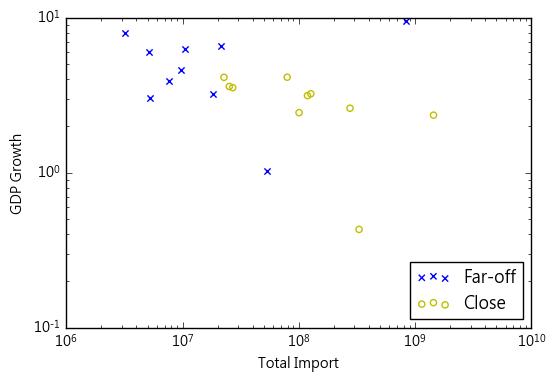

In [21]:
anova_dt_faroff = anova_dt.loc[anova_dt.index.isin(faroff.index), ['gdp_growth', 'im']]
anova_dt_closest = anova_dt.loc[anova_dt.index.isin(closest.index), ['gdp_growth', 'im']]
plt.scatter(anova_dt_faroff['im'], anova_dt_faroff['gdp_growth'], c='b', marker='x')
plt.scatter(anova_dt_closest['im'], anova_dt_closest['gdp_growth'], facecolors='none', edgecolors='y')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Total Import')
plt.ylabel('GDP Growth')
plt.legend(['Far-off', 'Close'], loc='lower right')
plt.show()

The decision boundary is somewhat clean-cut. So our guess was indeed correct: the less total import and the higher GDP growth a country has, the more far-off the predicted values are.

## Model 3: SVR

#### Cross Validation Curve

In [22]:
def cv_curve(data, X, model, **params):
    """Plot cross validation curve.
    
    The target parameter is optimized on the training set (70% of data) using grid search.
    
    Keyword arguments:
    ------------------
    **params -- model parameters as key/value pairs. Exactly one of the parameters should be provided
                with a list of values for comparing cv errors.
    """
    cv_param = [{k:v} for k, v in params.items() if type(v) == list][0]
    others = {k:v for k, v in params.items() if type(v) != list}
    cv_param_pairs = [[{key:val} for val in vals] for key, vals in cv_param.items()][0]
    train_errors = []
    test_errors = []
    for pair in cv_param_pairs:
        mdl = ExportGrowthModel(
            data=data, X=X, y='ex_growth',
            model=model, **pair, **others, scale=True, cv_method='sampling',
            n_train=round(len(data) * .7))
        train_errors.append(mdl.train_error)
        test_errors.append(mdl.test_error)
    param = list(cv_param.keys())[0]
    curve_dt = pd.DataFrame(
        dict(param=list(cv_param.values())[0], train_error=train_errors, test_error=test_errors))
    curve_dt.plot(x='param', y=['train_error', 'test_error'])
    plt.title('Cross Validation Curve for "{}"'.format(param))
    plt.xlabel('{}'.format(param))
    plt.ylabel('Error')
    plt.legend(['Train', 'Test'])
    plt.show()
    optimal = curve_dt.loc[curve_dt['test_error'] == curve_dt['test_error'].min(), 'param'].values[0]
    print('Optimal {} = {}'.format(param, optimal))
    return optimal

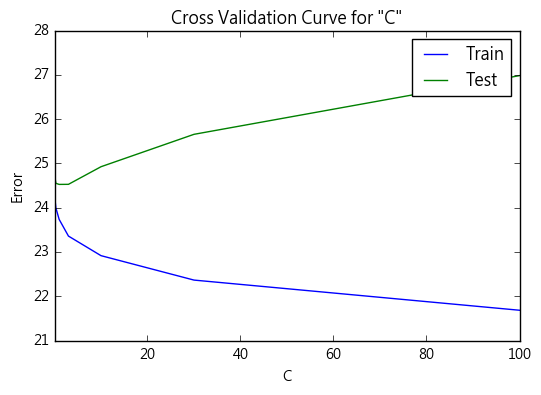

Optimal C = 1.0


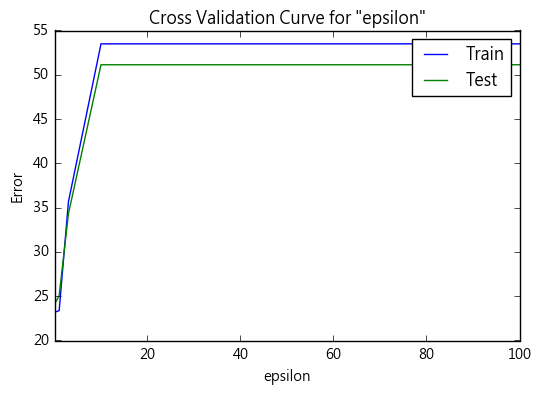

Optimal epsilon = 0.3


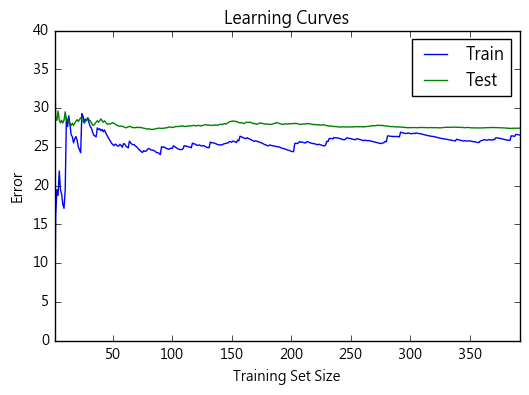

In [23]:
optimal_C = cv_curve(outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], model='svr',
                     kernel='rbf', C=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])
optimal_epsilon = cv_curve(outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], model='svr',
                           kernel='rbf', C=3,
                           epsilon=[0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100])
learning_curves(outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'],
                model='svr', kernel='rbf', C=optimal_C, epsilon=optimal_epsilon)

In [24]:
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='svr', kernel='rbf', C=optimal_C, epsilon=optimal_epsilon, scale=True,
                  cv_method='leave_one_out')
ExportGrowthModel(data=outlier_rm, X=['gdp_growth', 'capita_growth', 'im_growth'], y='ex_growth',
                  model='svr', kernel='rbf', C=optimal_C, epsilon=optimal_epsilon, scale=True,
                  cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 23.6458
- Test : 24.1896
Stratefied 5-fold cv errors:
- Train: 23.6112
- Test : 24.3535


## Model 4: Random Forests

In [25]:
dummies = pd.get_dummies(outlier_rm.index.get_level_values('country'), drop_first=True)
dummies.index = outlier_rm.index
ddf = pd.concat([outlier_rm, dummies], axis=1)

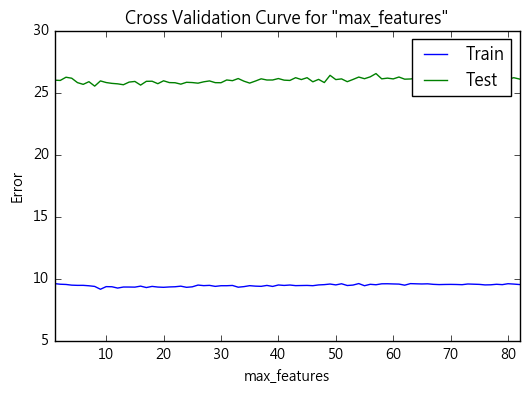

Optimal max_features = 8


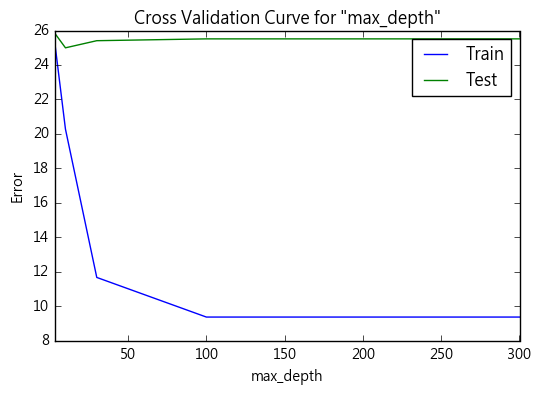

Optimal max_depth = 10


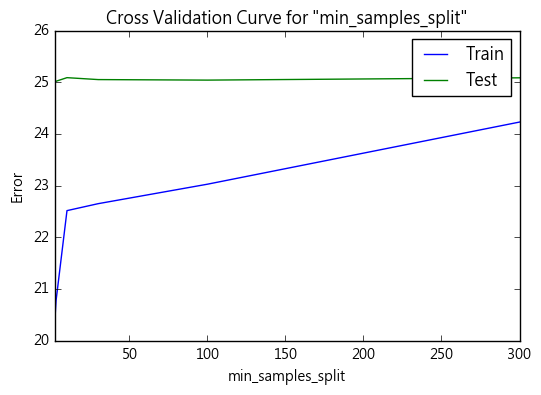

Optimal min_samples_split = 2


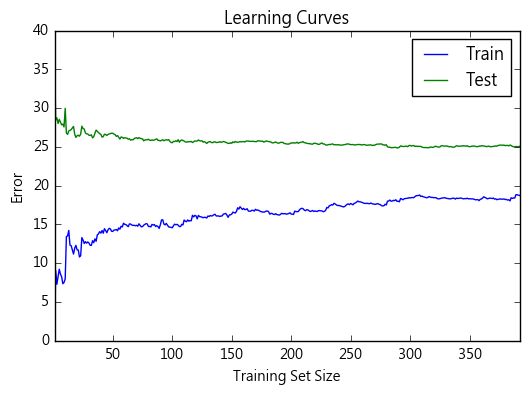

In [26]:
optimal_max_features = cv_curve(ddf, X=ddf.columns[1:], model='rf', n_estimators=100,
                                max_features=list(range(1, len(ddf.columns))), random_state=3)
optimal_max_depth = cv_curve(ddf, X=ddf.columns[1:], model='rf', n_estimators=100,
                             max_features=optimal_max_features, random_state=3,
                             max_depth=[3, 10, 30, 100, 300])
optimal_min_samples_split = cv_curve(ddf, X=ddf.columns[1:], model='rf', n_estimators=100,
                                     max_features=optimal_max_features, random_state=3,
                                     max_depth=optimal_max_depth,
                                     min_samples_split=[2, 3, 10, 30, 100, 300])
learning_curves(ddf, X=ddf.columns[1:], model='rf', n_estimators=100,
                max_features=optimal_max_features, random_state=3, max_depth=optimal_max_depth,
                min_samples_split=optimal_min_samples_split)

Although there's still a large gap between training errors and test errors, random forests appears to fit the training set relatively well. We suspect there may be some test set examples that look nothing like what the algorithm has seen in the training set. Later we'll train on more data and see if it's possible to further reduce test errors.

In [27]:
ExportGrowthModel(data=ddf, X=ddf.columns[1:], y='ex_growth', model='rf', n_estimators=100,
                  max_features=optimal_max_features, random_state=3, max_depth=optimal_max_depth,
                  min_samples_split=optimal_min_samples_split, scale=True, cv_method='leave_one_out')
ExportGrowthModel(data=ddf, X=ddf.columns[1:], y='ex_growth', model='rf', n_estimators=100,
                  max_features=optimal_max_features, random_state=3, max_depth=optimal_max_depth,
                  min_samples_split=optimal_min_samples_split, scale=True, cv_method='skf', n_splits=5)

Leave-one-out cv errors:
- Train: 21.0324
- Test : 24.7262
Stratefied 5-fold cv errors:
- Train: 20.8726
- Test : 24.8726


Once again, random forests is the algorithm with the highest variance we have so far.

## Model 5: AdaBoost

## Model 6: Gradient Boosting

## Model 7: SARIMA

#### Scrape Monthly Export Data

In [28]:
import datetime
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from io import StringIO

def get_mof_ts():
    
    current_year = datetime.datetime.now().year - 1911
    url = 'https://portal.sw.nat.gov.tw/APGA/GA06_csv'
    # Suppress InsecureRequestWarning
    requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

    def get_data(year):
        payload = {'searchInfo.StartYear': str(year),
                   'searchInfo.EndYear': '',
                   'searchInfo.StartMonth': '1',
                   'searchInfo.EndMonth': '12',
                   'searchInfo.TypeTime': '0',
                   'searchInfo.Type': 'MoneyUSD',
                   'searchInfo.CountryName': '全部國家合計,千里達,土耳其,土庫曼,大溪地,不丹,中非,中國大陸,丹麥,厄瓜多,厄利垂亞,巴布亞紐幾內亞,巴西,巴貝多,巴拉圭,巴林,巴哈馬,巴拿馬,巴勒斯坦,巴基斯坦,日本,比利時,牙買加,以色列,加拿大,加彭,北韓,卡達,古巴,史瓦濟蘭,尼日,尼加拉瓜,尼泊爾,布吉納法索,未列名法屬中美洲領域,未列名美屬中美洲領域,未列名美屬太平洋領域,未列名英屬中美洲領域,瓜地馬拉,甘比亞,白俄羅斯,立陶宛,伊拉克,伊朗,冰島,列支敦斯登,匈牙利,印尼,印度,吉布地,吉里巴斯,吉爾吉斯,吐瓦魯,多米尼克,多明尼加,多哥,安地卡,安圭拉,安哥拉,安道爾,衣索比亞,西班牙,西撒哈拉,克羅埃西亞,利比亞,宏都拉斯,希臘,沙烏地阿拉伯,汶萊,貝里斯,貝南,赤道幾內亞,辛巴威,亞美尼亞,亞塞拜然,其他大洋洲國家,其他中東及近東國家,其他中美洲國家,其他北美洲國家,其他亞洲國家,其他非洲國家,其他南美洲國家,其他國家,其他歐洲國家,坦尚尼亞,奈及利亞,委內瑞拉,孟加拉,尚比亞,帛琉,拉脫維亞,東加,波士尼亞赫塞哥維納,波札那,波多黎各,波蘭,法國,法屬圭亞那,肯亞,芬蘭,阿拉伯聯合大公國,阿根廷,阿曼,阿富汗,阿爾及利亞,阿爾巴尼亞,保加利亞,俄羅斯,南非,南韓,南蘇丹,哈薩克,柬埔寨,查德,玻利維亞,科威特,突尼西亞,約旦,美國,美屬薩摩亞,茅利塔尼亞伊斯蘭共和國,英國,迦納,香港,剛果,剛果民主共和國,哥倫比亞,哥斯大黎加,埃及,挪威,格陵蘭,格瑞那達,泰國,海地,烏干達,烏克蘭,烏拉圭,烏茲別克,琉球,秘魯,索馬利亞,索羅門群島,紐西蘭,納米比亞,納維斯,馬利,馬來西亞,馬其頓,馬拉威,馬約特,馬紹爾群島共和國,馬達加斯加,馬爾他,馬爾地夫,捷克,捷克,教廷,敘利亞,莫三比克,荷蘭,喀麥隆,喬治亞,幾內亞,幾內亞比索,斐濟,斯里蘭卡,斯洛伐克,斯洛維尼亞,智利,菲律賓,象牙海岸,越南,塞內加爾,塞席爾,塞爾維亞,塞爾維亞與蒙特內哥羅,塔吉克,奧地利,愛沙尼亞,愛爾蘭,新加坡,新克里多尼亞,獅子山,瑞士,瑞典,萬那杜,義大利,聖文森,聖多美普林西比,聖克里斯多福,聖馬利諾,聖露西亞,葉門,葛摩聯盟,葡萄牙,維德角,蒙古,蒙特內哥羅共和國,蒙瑟拉特,蒲隆地,蓋亞那,寮國,德國,摩洛哥,摩納哥,摩爾多瓦,模里西斯,緬甸,黎巴嫩,墨西哥,澳大利亞,澳門,盧安達,盧森堡,諾魯,賴比瑞亞,賴索托,賽普勒斯,薩伊,薩爾瓦多,薩摩亞,羅馬尼亞,關島,蘇丹,蘇利南,蘇聯',
                   'noData': 'false'}
        resp = requests.post(url, data=payload, verify=False)
        skiprows = None
        # For data after 2016, need to remove header "註：105年起按一般貿易制度編製。"
        if year >= 105: skiprows = 1
        # Get data in bytes, decode, and convert to dataframe
        df = pd.read_csv(StringIO(resp.content.decode(encoding='big5')), skiprows=skiprows)[
            ['日期', '國家', '出口總值']]
        return df

    df_map = map(lambda x: get_data(x), range(92, current_year + 1))
    df = reduce(lambda x, y: pd.concat([x, y], axis=0, ignore_index=True), df_map)

    # Parse into year and month
    df[['year', 'month']] = df['日期'].str.extract('(\d+)年(\d+)月', expand=False)
    # Create DatetimeIndex
    df.index = pd.to_datetime((df['year'].astype(int) + 1911).astype(str) + '-' + df['month'],
                              format='%Y-%m')
    df.index.name = 'date'
    # Keep only useful columns
    df = df[['國家', '出口總值']]
    df.columns = ['country', 'export']
    # Reshape
    df = pd.pivot_table(df, index=df.index, columns='country', values='export', fill_value=0)

    # Sum of southbound eighteen and ten
    eighteen = ['不丹', '印尼', '印度', '孟加拉', '寮國', '尼泊爾', '巴基斯坦', '斯里蘭卡', '新加坡',
                '柬埔寨', '汶萊', '泰國', '澳大利亞', '紐西蘭', '緬甸', '菲律賓', '越南', '馬來西亞']
    ten = ['印尼', '寮國', '新加坡', '柬埔寨', '汶萊', '泰國', '緬甸', '菲律賓', '越南', '馬來西亞']
    df['十八國'] = df.loc[:, eighteen].sum(axis=1)
    df['十國'] = df.loc[:, ten].sum(axis=1)
    df.to_csv('export_ts.csv', encoding='utf-8')
    return

# ts = get_mof_ts()
ts = pd.read_csv('export_ts.csv', index_col='date', parse_dates=True)

#### Case Study: USA

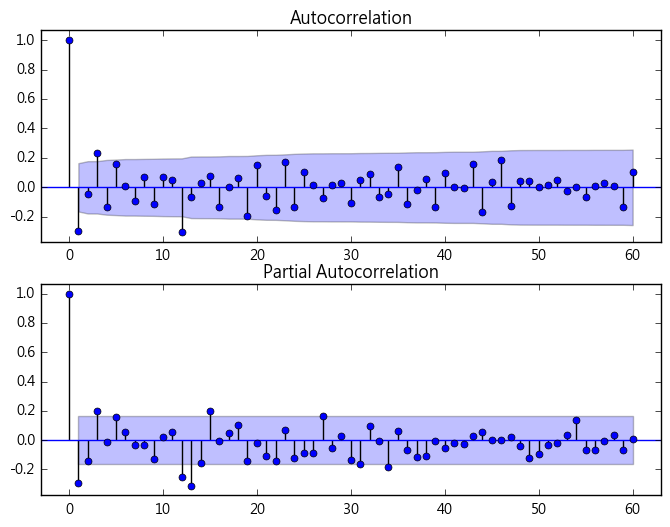

In [29]:
%matplotlib inline

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Maximum Likelihood optimization failed to converge.')
    import statsmodels.api as sm

backtest = 2016
x = ts[['美國']].copy()
lx = np.log(x.loc[:str(backtest-1)])
dlx = lx - lx.shift()
ddlx = dlx - dlx.shift(12)
ddlx.dropna(inplace=True)

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ddlx, ax=ax1, lags=60)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ddlx, ax=ax2, lags=60)

Both ACF and PACF appear to tail off at seasonal and non-seasonal lags. We'll use grid search to fit the parameters.

In [30]:
from itertools import product

def optimize_aic(ts):

    def aic(ts, params):
        p, q, P, Q = params
        try:
            fit = sm.tsa.statespace.SARIMAX(ts, order=(p, 1, q), seasonal_order=(P, 1, Q, 12)).fit()
        except (ValueError, np.linalg.LinAlgError):
            return p, q, P, Q, None
        return p, q, P, Q, fit.aic
    
    gridpoints = list(product(range(4), range(4), range(4), range(4)))
    rs = pd.DataFrame(list(map(lambda x: aic(ts, x), gridpoints)))
    rs.columns = ['p', 'q', 'P', 'Q', 'aic']
    p, q, P, Q = tuple(int(x) for x in rs.ix[rs['aic'].idxmin(), 'p':'Q'].values)
    return p, q, P, Q

C:\Users\2093\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                                 美國   No. Observations:                  156
Model:             SARIMAX(3, 1, 0)x(0, 1, 1, 12)   Log Likelihood                 190.726
Date:                            Wed, 12 Apr 2017   AIC                           -371.453
Time:                                    17:43:07   BIC                           -356.203
Sample:                                01-01-2003   HQIC                          -365.259
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3784      0.087     -4.371      0.000      -0.548      -0.209
ar.L2         -0.1383      0.085   

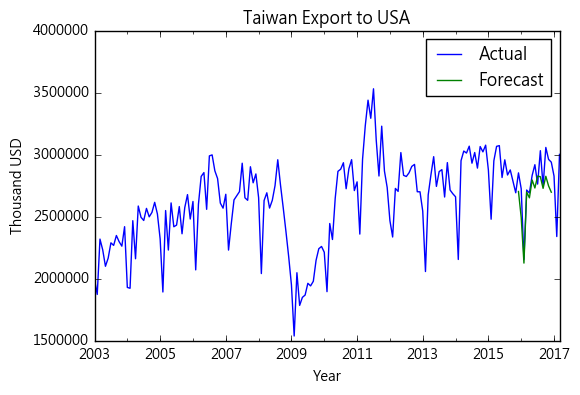

In [31]:
%%time

p, q, P, Q = optimize_aic(lx)
rs = sm.tsa.statespace.SARIMAX(lx, order=(p, 1, q), seasonal_order=(P, 1, Q, 12)).fit(
    mle_regression=True, warn_convergence=True)
print(rs.summary())
x['forecast'] = np.exp(
    rs.predict(start='{}-12-01'.format(backtest-1), end='{}-12-01'.format(backtest), dynamic=True))
x.plot()
plt.title('Taiwan Export to USA')
plt.xlabel('Year')
plt.ylabel('Thousand USD')
plt.legend(['Actual', 'Forecast'])

#### Automation

## Model 8: Neural Network

## Ensemble 1: Averaging Ensemble

## Ensemble 2: Standard Linear Regression Stacking

$$b(x) = \sum_i w_i g_i(x),\forall x$$

## Ensemble 3: Feature-Weighted Linear Stacking (FWLS)

$$b(x) = \sum_{i, j}\ v_{ij}\ f_j(x)\ g_i(x), \forall x$$

where $f_j$ are meta-feature functions.